In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
from config import get_arguments
from models import ClusterNetSmooth, ClusterNet, TAE
from load_data import get_loader
from train import (
    training_function,
    pretrain_autoencoder,
    initalize_centroids,
)
from sklearn.metrics import roc_auc_score
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt


### Loading ucr dataset 

In [2]:
data = {
    "BeetleFly": 8,
    "BirdChicken": 8,
    "Computers": 10,
    "Earthquakes": 8,
    "MoteStrain": 4,
    "PhalangesOutlinesCorrect": 4,
    "ProximalPhalanxOutlineCorrect": 4,
    "ShapeletSim": 10,
    "ItalyPowerDemand": 4,
    "WormsTwoClass": 10,
}



### Heatmap

In [3]:
similarity="EUC"
window_size=5
step =2
dataset_name = "MoteStrain"
command = f"--similarity {similarity} --pool {1} --dataset_name {dataset_name} --window_size {window_size} --step {step} --smooth --no_autoencoder --heatmap"
parser = get_arguments()
args = parser.parse_args(command.split(" "))
args.path_data = args.path_data.format(args.dataset_name + str(window_size) + str(step) + str(similarity) )
if not os.path.exists(args.path_data):
    os.makedirs(args.path_data)

path_weights = args.path_weights.format(args.dataset_name + str(window_size) + str(step) + str(similarity) )
if not os.path.exists(path_weights):
    os.makedirs(path_weights)

args.path_weights_ae = os.path.join(path_weights, "autoencoder_weight.pth")
args.path_weights_main = os.path.join(path_weights, "full_model_weigths.pth")

args.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trainloader, X_scaled = get_loader(args)
for e in trainloader:
    for a in e:
        print(f"x shape {a.shape}")
        n_hidden = a.shape[-1]
        break
    break
args.n_hidden = n_hidden
if args.no_autoencoder:
    ### Clustering without autoencoder
    model = ClusterNetSmooth(args)
    loss1 = None

model = model.to(args.device)
initalize_centroids(X_scaled, args, model)

optimizer_clu = torch.optim.SGD(
    model.parameters(), lr=args.lr_cluster, momentum=args.momentum
)
max_roc_score = training_function(
    trainloader, X_scaled, model, optimizer_clu, loss1, args
)

x shape torch.Size([256, 1, 40])
Training full model ...


/home/vayvi/.local/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


For epoch 0 Loss is :  0.748 

For epoch 1 Loss is :  0.604 

For epoch 2 Loss is :  0.414 

For epoch 3 Loss is :  0.251 

For epoch 4 Loss is :  0.147 

For epoch 5 Loss is :  0.092 

For epoch 6 Loss is :  0.064 

For epoch 7 Loss is :  0.047 

For epoch 8 Loss is :  0.034 

For epoch 9 Loss is :  0.021 

For epoch 10 Loss is :  0.012 

For epoch 11 Loss is :  0.006 

For epoch 12 Loss is :  0.003 

For epoch 13 Loss is :  0.002 

For epoch 14 Loss is :  0.001 

For epoch 15 Loss is :  0.001 

For epoch 16 Loss is :  0.000 

For epoch 17 Loss is :  0.000 

For epoch 18 Loss is :  0.000 

For epoch 19 Loss is :  0.000 

For epoch 20 Loss is :  0.000 

For epoch 21 Loss is :  0.000 

For epoch 22 Loss is :  0.000 

For epoch 23 Loss is :  0.000 

For epoch 24 Loss is :  0.000 

For epoch 25 Loss is :  0.000 

For epoch 26 Loss is :  0.000 

For epoch 27 Loss is :  0.000 

For epoch 28 Loss is :  0.000 

For epoch 29 Loss is :  0.000 

For epoch 30 Loss is :  0.000 

For epoch 31 Loss 

### Loading the saved trained model 

In [4]:

# load the saved state dictionary
state_dict = torch.load(args.path_weights_main)

# load the state dictionary into the model
model.load_state_dict(state_dict)

<All keys matched successfully>

In [5]:
X, y = next(iter(trainloader))
_,_,res, _  = model.forward(X.float())


In [6]:

pos, neg = 0, 0
pos_indices, neg_indices = [], []

for i in range(50):
    label = y[i].item()
    if int(label) and pos<5:
        pos += 1
        pos_indices.append(i)
    else:
        neg += 1
        neg_indices.append(i)
    if (pos>4) and (neg> 4):
        break

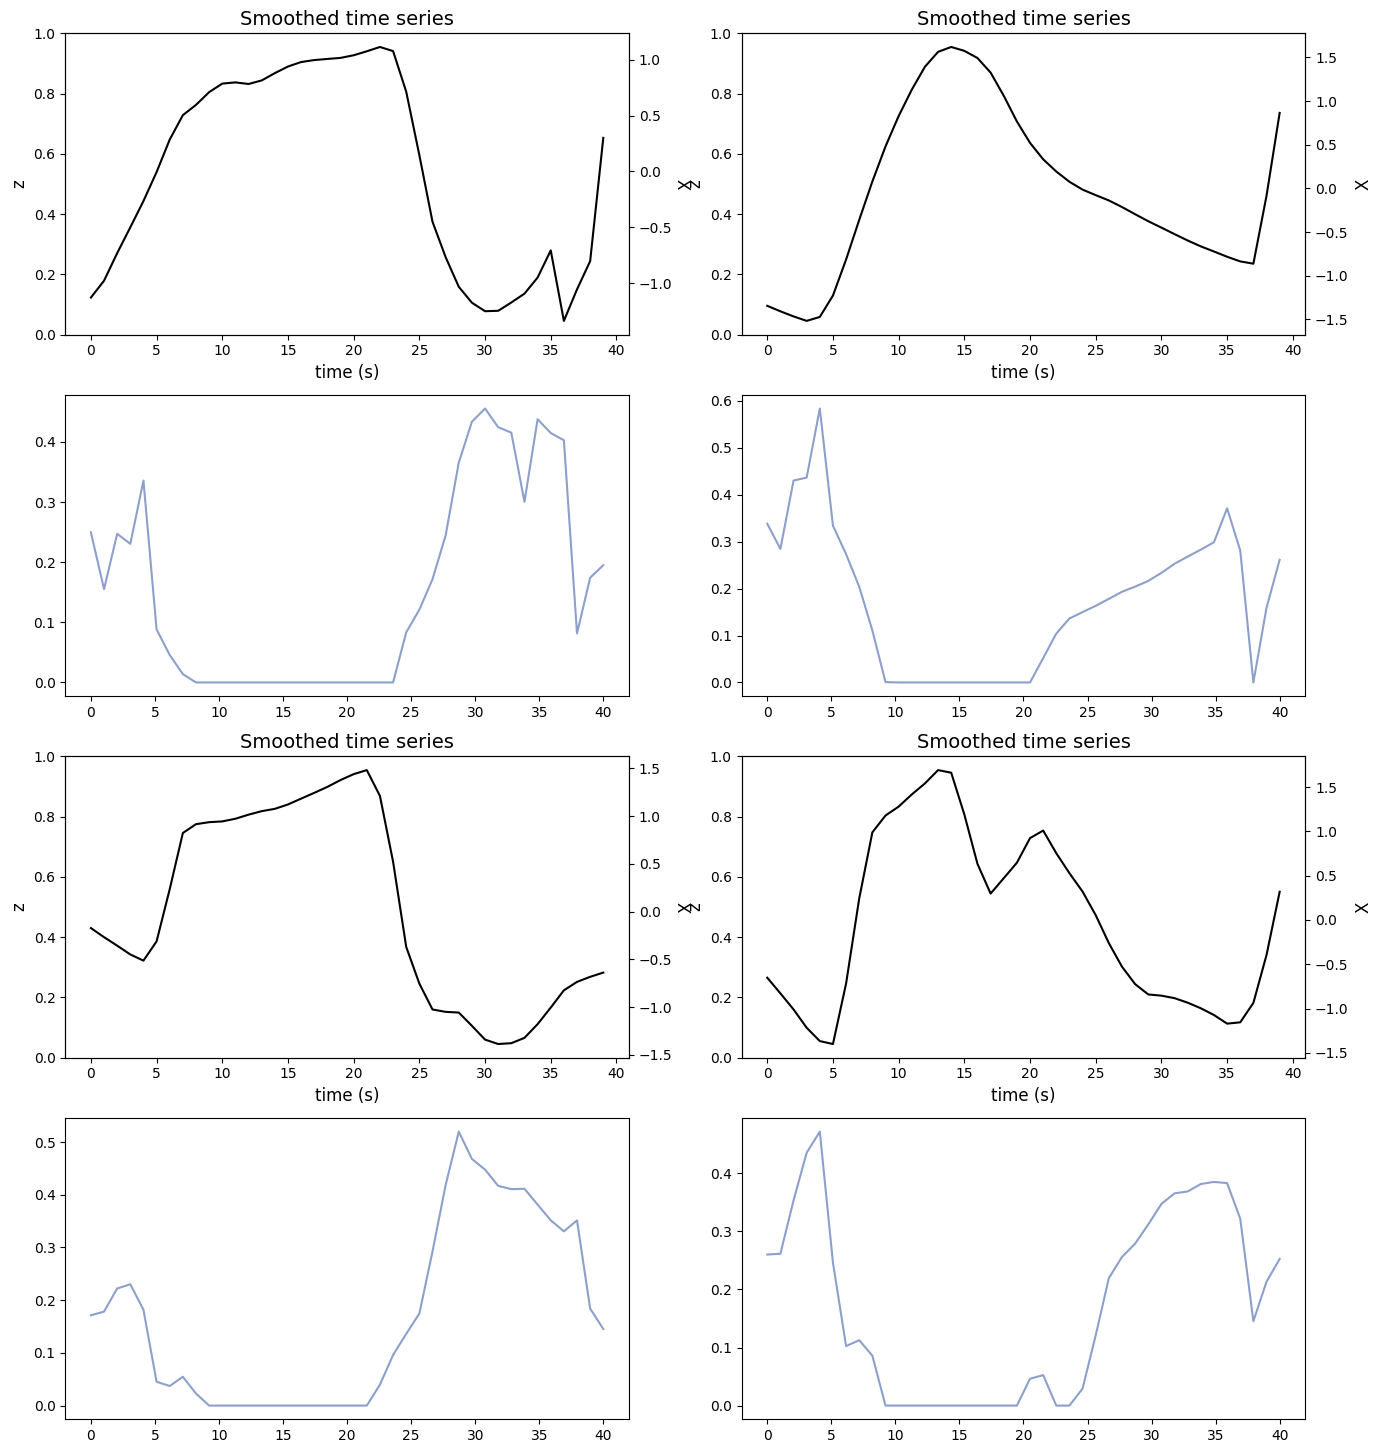

In [13]:
fig, axs = plt.subplots(4, 2, figsize=(16, 18))
line_colors = ["#66c2a5", "#8da0cb"]
bg_color = "#f7f7f7"
X_size = X[0, 0, :].shape
# plot the positive label subplots
k=0
for i in range(0,4, 2):
    hmap_size = res[pos_indices[k], :][0].shape[0]
    axs[i][0].set_title("Smoothed time series", fontsize=14)
    axs[i][0].set_xlabel("time (s)", fontsize=12)
    axs[i][0].set_ylabel("z", fontsize=12)
    # axs[i+1][0].plot(np.linspace(0, X_size, hmap_size), res[pos_indices[k], :][0].detach(), color=line_colors[0])
    axs[i+1][0].plot(np.linspace(0, X_size, hmap_size), res[pos_indices[k], :][1].detach(), color=line_colors[1])
    axs[i][0].tick_params(axis="both", labelsize=10, grid_alpha=0.5)
    axs[i+1][0].tick_params(axis="both", labelsize=10, grid_alpha=0.5)

    ax2 = axs[i][0].twinx()
    ax2.set_ylabel("X", color="black", fontsize=12)
    ax2.plot(X[pos_indices[k], 0, :].detach(), color="black")
    ax2.tick_params(axis="y", labelcolor="black", labelsize=10, grid_alpha=0.5)
 

# plot the negative label subplots
    axs[i][1].set_title("Smoothed time series", fontsize=14)
    axs[i][1].set_xlabel("time (s)", fontsize=12)
    axs[i][1].set_ylabel("z", fontsize=12)
    # axs[i+1][1].plot(np.linspace(0, X_size, hmap_size), res[neg_indices[k], :][0].detach(), color=line_colors[0])
    axs[i+1][1].plot(np.linspace(0, X_size, hmap_size), res[neg_indices[k], :][1].detach(), color=line_colors[1])
    axs[i][1].tick_params(axis="both", labelsize=10, grid_alpha=0.5)
    axs[i+1][1].tick_params(axis="both", labelsize=10, grid_alpha=0.5)

    ax2 = axs[i][1].twinx()
    ax2.set_ylabel("X", color="black", fontsize=12)
    ax2.plot(X[neg_indices[k], 0, :].detach(), color="black")
    ax2.tick_params(axis="y", labelcolor="black", labelsize=10, grid_alpha=0.5)
    k=k+1
 
 